<a href="https://colab.research.google.com/github/aman5319/Meetup2019/blob/master/Session4/TransferLearning%26ManyMore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  **Creating your own Dataset from Google Images**
   Inspired By Fastai  Library

### In this tutorial we will see how to easily create an image dataset through Google Images and load them in keras

Note The code has been taken from fastai library and tailored for keras



## Get a list of URLs
## Search and scroll

Go to [Google Images](https://images.google.com/) and search for the images you are interested in. The more specific you are in your Google Search, the better the results and the less manual pruning you will have to do.

Scroll down until you see a button that says **Show more results** . All the images you scrolled past are now available to download. To get more, click on the button. Then continue scrolling until you cannot scroll anymore. The maximum number of images Google Images shows is 700.

## Download into file

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

Press Ctrl+Shift+J in Windows/Linux and Cmd+Opt+J in Mac for Chrome and Ctrl+Shift+K in Firefox, a small window the javascript 'Console' will appear. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. You can do this by running the following commands:



```javascript
urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));
```




## In this tutorial, we are working on birds datasets.

Here we have images of 10 different birds species found in India.
So the steps are as following
1. Make 10 CSV files of all the different birds in your local system by following above steps
2. Zip it and upload it to Google colab
3. Unzip it, download all the Images in their specific folder
4. Verify all the Images 
5. Use It and Enjoy

In [0]:
# import all the library's
!pip install torch torchvision
!pip install Pillow==4.0.0

from tqdm import tqdm ,trange# for progress bar 
import os,sys,requests 
from concurrent.futures import ProcessPoolExecutor ,as_completed # Asynchronous Execution
import numpy as np 
import matplotlib.pyplot as plt
from pathlib import Path

import torch
from torch import nn
import torch.nn.functional  as F
from torch.utils.data import Dataset , DataLoader

import torchvision
from torchvision import transforms ,models

    100% |████████████████████████████████| 591.8MB 20kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x61dd0000 @  0x7f36f42ef2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 24.7MB/s 
    100% |████████████████████████████████| 2.0MB 7.0MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
  [PIL]
You must restart the runtime in order to use newly installed versions.
    100% |████████████████████████████████| 5.6MB 7.1MB/s 
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.4.1
    Uninstalling Pillow-5.4.1:
      Successfully uninstalled Pillow-5.4.1
  [P

In [0]:
# Upload the ziped file 
from google.colab import files
uploaded = files.upload()

Saving Birds.zip to Birds.zip


In [0]:
!unzip Birds.zip
!ls -l Birds

Archive:  Birds.zip
   creating: Birds/
  inflating: Birds/Asian Paradise Flycatcher.csv  
  inflating: Birds/Himalayan Monal.csv  
  inflating: Birds/Indian Pitta.csv  
  inflating: Birds/Mrs. Gould’s Sunbird.csv  
  inflating: Birds/Oriental Dwarf Kingfisher.csv  
  inflating: Birds/Red Headed Trogon.csv  
  inflating: Birds/Sarus Crane.csv   
  inflating: Birds/Satyr Tragopan.csv  
  inflating: Birds/parrot.csv        
  inflating: Birds/peacock.csv       
total 620
-rw-rw-r-- 1 root root 61740 Nov  3 19:23 'Asian Paradise Flycatcher.csv'
-rw-rw-r-- 1 root root 48812 Nov  3 19:20 'Himalayan Monal.csv'
-rw-rw-r-- 1 root root 60080 Nov  3 19:15 'Indian Pitta.csv'
-rw-rw-r-- 1 root root 54367 Nov  3 19:12 'Mrs. Gould’s Sunbird.csv'
-rw-rw-r-- 1 root root 59841 Nov  3 19:06 'Oriental Dwarf Kingfisher.csv'
-rw-rw-r-- 1 root root 85959 Nov  3 18:43  parrot.csv
-rw-rw-r-- 1 root root 77909 Nov  3 18:37  peacock.csv
-rw-rw-r-- 1 root root 55118 Nov  3 19:05 'Red Headed Trogon.csv'
-rw-rw-r-

In [0]:
def download_url(url:str, dest:str, overwrite:bool=False, chunk_size=1024*1024, timeout=4):
    "Download `url` to `dest` unless it exists and not `overwrite`."
    if os.path.exists(dest) and not overwrite: return

    u = requests.get(url, stream=True, timeout=timeout)
    try: file_size = int(u.headers["Content-Length"])
    except: pass
        
    with open(dest, 'wb') as f:
        for chunk in u.iter_content(chunk_size=chunk_size):
            f.write(chunk)

def download_images(urls:str, dest:Path, max_pics:int=1000, max_workers:int=8, timeout=4,prefix=None,show_progress=True):
    "Download images listed in text file urls to path dest , at most max_pics"
    urls = open(urls).read().strip().split("\n")[:max_pics] # get all the urls in the list
    dest = Path(dest) # get the path of the folder 
    dest.mkdir(exist_ok=True) # create all the parent and child directory if neccessary. 

    if max_workers: # use the power of multiprocessing
        with ProcessPoolExecutor(max_workers=max_workers) as ex: # use a ProcessPoolExecutor for using pool of process to execute call asynchronously.
             # submit schedules the callable and return a Future object on completion. We iterate through all the urls to create Future objects for each url 
            futures = [ex.submit(download_url, url, dest/f"{i:08d}.jpg", timeout=timeout) for i,url in enumerate(urls)]
            if show_progress : 
                for f in tqdm(as_completed(futures), total=len(urls),desc=prefix): pass # show th progress bar

In [0]:
# get the path for all csv files
birdspath = Path("Birds")
birdspath = [ Path(child) for child in birdspath.iterdir()]
birdspath

[PosixPath('Birds/Oriental Dwarf Kingfisher.csv'),
 PosixPath('Birds/peacock.csv'),
 PosixPath('Birds/parrot.csv'),
 PosixPath('Birds/Red Headed Trogon.csv'),
 PosixPath('Birds/Sarus Crane.csv'),
 PosixPath('Birds/Himalayan Monal.csv'),
 PosixPath('Birds/Mrs. Gould’s Sunbird.csv'),
 PosixPath('Birds/Satyr Tragopan.csv'),
 PosixPath('Birds/Asian Paradise Flycatcher.csv'),
 PosixPath('Birds/Indian Pitta.csv')]

In [0]:
import re
from pprint import pprint 
all_birds_Name = [re.sub(r".csv|\.\s|\s*|\’" , r"", x.name) for x in birdspath] # Get all the birds name from the csv file
pprint(all_birds_Name)
folder_file = {x:y for x ,y in zip(all_birds_Name , birdspath)} # create a folder name the file name dictionary 
pprint(folder_file)

['OrientalDwarfKingfisher',
 'peacock',
 'parrot',
 'RedHeadedTrogon',
 'SarusCrane',
 'HimalayanMonal',
 'MrsGould’sSunbird',
 'SatyrTragopan',
 'AsianParadiseFlycatcher',
 'IndianPitta']
{'AsianParadiseFlycatcher': PosixPath('Birds/Asian Paradise Flycatcher.csv'),
 'HimalayanMonal': PosixPath('Birds/Himalayan Monal.csv'),
 'IndianPitta': PosixPath('Birds/Indian Pitta.csv'),
 'MrsGould’sSunbird': PosixPath('Birds/Mrs. Gould’s Sunbird.csv'),
 'OrientalDwarfKingfisher': PosixPath('Birds/Oriental Dwarf Kingfisher.csv'),
 'RedHeadedTrogon': PosixPath('Birds/Red Headed Trogon.csv'),
 'SarusCrane': PosixPath('Birds/Sarus Crane.csv'),
 'SatyrTragopan': PosixPath('Birds/Satyr Tragopan.csv'),
 'parrot': PosixPath('Birds/parrot.csv'),
 'peacock': PosixPath('Birds/peacock.csv')}


In [0]:
# download all the images 
for folder,file in folder_file.items():
    path = Path("train") # create a parent directory   
    dest = path/folder # Specific folder for each bird
    dest.mkdir(parents=True,exist_ok=True)
    download_images(file, dest,prefix=folder,max_workers=16)

IndianPitta: 100%|██████████| 648/648 [00:37<00:00, 17.50it/s]


In [0]:
length = lambda iterrator : len(tuple(iterrator))
birdsPerClassCount = { (path/folder).name : length((path/folder).iterdir()) for folder,file in folder_file.items() }
sorted(birdsPerClassCount.items() , key=lambda x :x[1])

[('HimalayanMonal', 500),
 ('MrsGould’sSunbird', 514),
 ('SatyrTragopan', 514),
 ('OrientalDwarfKingfisher', 541),
 ('RedHeadedTrogon', 548),
 ('SarusCrane', 592),
 ('AsianParadiseFlycatcher', 610),
 ('IndianPitta', 634),
 ('peacock', 801),
 ('parrot', 837)]

In [0]:
import PIL
def verify_image(file:Path, delete:bool ,dest:Path=None, n_channels:int=3, **kwargs):
    """Check if the image in `file` exists, can be opend and has `n_channels`. If `delete`, removes it if it fails.
        Result is stored in `dest` `img_format` and `kwargs` are passed to PIL.Image.save."""
    try:
        img = PIL.Image.open(file)
        assert isinstance(dest, Path), "You should provide `dest` Path to save resized image"
        if not file.is_file(): return
        if n_channels == 3: img = img.convert("RGB")
        img.save(file, **kwargs)
        img = np.array(img)
        img_channels = 1 if len(img.shape) == 2 else img.shape[2]
        assert img_channels == n_channels, f"Image {file} has {img_channels} instead of {n_channels}"
    except Exception as e:
        #print(f'{e}')
        if delete: file.unlink()

def verify_images(path:Path, delete:bool=True, max_workers:int=4 , dest:Path=".",n_channels:int=3,**kwargs):
    """Check if the image in `path` exists, can be opened and has `n_channels`.
    If `n_channels` is 3 – it'll try to convert image to RGB. If `delete`, removes it if it fails.
    If `max_size` is specifided,
    image is resized to the same ratio so that both sizes are less than `max_size`, using `interp`.
    Result is stored in `dest`, `ext` forces an extension type, `img_format` and `kwargs` are
    passed to PIL.Image.save. Use `max_workers` CPUs."""
    dest = path/Path(dest)
    dest.mkdir(exist_ok=True)
    with ProcessPoolExecutor(max_workers=max_workers) as ex:
        files = [Path(file) for file in path.iterdir()]
        futures = [ex.submit(verify_image, file, delete=delete,dest=dest, n_channels=n_channels, **kwargs) for file in files]
    for f in tqdm(as_completed(futures), total=len(files) , desc=path.name): pass

In [0]:
for folder,file in folder_file.items():
    path = Path("train")
    verify_images(path/folder,delete=True)

OrientalDwarfKingfisher: 100%|██████████| 541/541 [00:00<00:00, 202654.15it/s]
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:872: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:872: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
parrot: 100%|██████████| 837/837 [00:00<00:00, 208829.48it/s]
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:872: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
MrsGould’sSunbird: 100%|██████████| 514/514 [00:00<00:00, 197496.54it/s]
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:872: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:872: UserWarning: 

In [0]:
birdsPerClassCountVerify = { (path/folder).name :len([*(path/folder).iterdir()]) for folder,file in folder_file.items() }
sorted(birdsPerClassCountVerify.items() , key=lambda x :x[1])

[('HimalayanMonal', 487),
 ('MrsGould’sSunbird', 493),
 ('SatyrTragopan', 499),
 ('OrientalDwarfKingfisher', 512),
 ('RedHeadedTrogon', 522),
 ('SarusCrane', 580),
 ('AsianParadiseFlycatcher', 581),
 ('IndianPitta', 608),
 ('parrot', 755),
 ('peacock', 762)]

# Transfer Learning

![](https://2s7gjr373w3x22jf92z99mgm5w-wpengine.netdna-ssl.com/wp-content/uploads/2016/06/transfer-learning.png)

In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest. The three major Transfer Learning scenarios look as follows:

  1.   ConvNet as fixed feature extractor : Here we take pretrained network chuck out the fully connected classifier part and use only the convolution layers as a feature extractor which can be used in Style Transfer or Deep Dream algorithms.

  2.    Fine-tuning the ConvNet : The model can be fine-tunned for a particular problem. For example in Dog vs Cat classification we can use the pretrained imagenet weights and can fine tune the convolution layer for dogs vs cats example.We can do this because imagenet dataset already contained Dogs and Cats example
  
  3.    Pretrained models: Since modern ConvNets take 2-3 weeks to train across multiple GPUs on ImageNet, it is common to see people release their final ConvNet checkpoints for the benefit of others who can use the networks for fine-tuning.



In [0]:
model = models.resnet50(pretrained=True) # load the pretrained model
num_features = model.fc.in_features # get the no of on_features in last Linear unit
print(num_features)
## freeze the entire convolution base
for param in model.parameters():
  param.requires_grad_(False)


2048


In [0]:
def create_head(num_features , number_classes ,dropout_prob=0.5 ,activation_func =nn.ReLU):
  features_lst = [num_features , num_features//2 , num_features//4]
  layers = []
  for in_f ,out_f in zip(features_lst[:-1] , features_lst[1:]):
    layers.append(nn.Linear(in_f , out_f))
    layers.append(activation_func())
    layers.append(nn.BatchNorm1d(out_f))
    if dropout_prob !=0 : layers.append(nn.Dropout(dropout_prob))
  layers.append(nn.Linear(features_lst[-1] , number_classes))
  return nn.Sequential(*layers)

top_head = create_head(num_features , len(birdsPerClassCount)) # because ten classes
model.fc = top_head # replace the fully connected layer

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [0]:
batch_size=32
transform = transforms.Compose([transforms.Resize((224,224)) , 
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                               ])
myDataset = torchvision.datasets.ImageFolder("train" , transform = transform)
valid_no  = int(0.2 * len(myDataset))
# so divide the data into trainset and testset
trainSet,testSet = torch.utils.data.random_split(myDataset,(len(myDataset)-valid_no,valid_no))
print(f"len of trainSet {len(trainSet)} , len of testSet {len(testSet)}")
trainLoader  = DataLoader(trainSet , batch_size=batch_size ,shuffle=True) 
testLoader  = DataLoader(testSet , batch_size=batch_size ,shuffle=True)
data_loader={"train":trainLoader , "val":testLoader}


len of trainSet 4640 , len of testSet 1159


In [0]:
import torch.optim as optim
from torch.optim import lr_scheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)
sgdr_partial = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.005 )

In [0]:
from tqdm import trange

def train(model , data_loader , criterion , optimizer ,scheduler, num_epochs=5):

  for epoch in trange(num_epochs,desc="Epochs"):
    result = []
    for phase in ['train', 'val']:
      if phase=="train":     # put the model in training mode
        model.train()
        scheduler.step()
      else:     # put the model in validation mode
        model.eval()
       
      # keep track of training and validation loss
      running_loss = 0.0
      running_corrects = 0.0  
      
      for data , target in data_loader[phase]:
        #load the data and target to respective device
        data , target = data.to(device)  , target.to(device)

        with torch.set_grad_enabled(phase=="train"):
          #feed the input
          output = model(data)
          #calculate the loss
          loss = criterion(output,target)
          preds = torch.argmax(output,1)

          if phase=="train"  :
            # backward pass: compute gradient of the loss with respect to model parameters 
            loss.backward()
            # update the model parameters
            optimizer.step()
            # zero the grad to stop it from accumulating
            optimizer.zero_grad()


        # statistics
        running_loss += loss.item() * data.size(0)
        running_corrects += torch.sum(preds == target.data).item()
        
        
      epoch_loss = running_loss / len(data_loader[phase].dataset)
      epoch_acc = running_corrects / len(data_loader[phase].dataset)

      result.append('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    print(result)
          
        

In [0]:
train(model,data_loader , criterion, optimizer,sgdr_partial)



Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epochs:  20%|██        | 1/5 [02:53<11:35, 173.97s/it]

['train Loss: 0.8862 Acc: 0.7388', 'val Loss: 0.4878 Acc: 0.8585']




Epochs:  40%|████      | 2/5 [05:49<08:43, 174.48s/it]

['train Loss: 0.6342 Acc: 0.8142', 'val Loss: 0.5412 Acc: 0.8516']




Epochs:  60%|██████    | 3/5 [08:42<05:47, 173.92s/it]

['train Loss: 0.5577 Acc: 0.8353', 'val Loss: 0.5198 Acc: 0.8525']




Epochs:  80%|████████  | 4/5 [11:35<02:53, 173.77s/it]

['train Loss: 0.4902 Acc: 0.8515', 'val Loss: 3.4336 Acc: 0.8758']




Epochs: 100%|██████████| 5/5 [14:28<00:00, 173.51s/it]



['train Loss: 0.4300 Acc: 0.8677', 'val Loss: 17.7310 Acc: 0.8732']


In [0]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.01
    lr: 0.005477457514062632
    weight_decay: 0
)

# Per Class Accuracy

In [0]:

def perClassAccuracy(model ,classes):
  class_correct = np.zeros(len(classes) ,dtype =np.int64 )
  class_total = np.zeros_like(class_correct,dtype =np.int64 )
  model.eval()
  
  for data ,target in data_loader["val"]:
    data,target =data.to(device) , target.to(device)
    with torch.set_grad_enabled(False):
      output =model(data)
      preds = torch.argmax(output,1)
      for prediction , label in zip(preds , target.data):
        if prediction == label:
          class_correct[prediction]+=1
        class_total[label]+=1
  per = np.round((100*class_correct/class_total) ,4)
  out = "\n".join([f"{name} :- {acc} %" for name ,acc in zip(classes , per)])
  return out+"\ntotal acc is {0}%".format(100* sum(class_correct)/sum(class_total))

print(perClassAccuracy(model , myDataset.classes))



AsianParadiseFlycatcher :- 95.2 %
HimalayanMonal :- 78.9474 %
IndianPitta :- 87.7193 %
MrsGould’sSunbird :- 72.4771 %
OrientalDwarfKingfisher :- 83.0189 %
RedHeadedTrogon :- 79.8165 %
SarusCrane :- 96.6102 %
SatyrTragopan :- 87.6404 %
parrot :- 92.4138 %
peacock :- 92.6174 %
total acc is 87.31665228645385%


# Visualizing the wrong prediction and where exactly model is confused Basically confusion matrix but I don't know how to do that so my new approach

In [0]:
def allwrong_prediction(classes ,model):
  test_array =[]
  model.eval()
  for data ,target in data_loader["val"]:
    data,target =data.to(device) , target.to(device)
    with torch.set_grad_enabled(False):
      output =model(data)
      preds = torch.argmax(output,1)
      for prediction , label in zip(preds , target.data):
        if prediction != label:
            test_array.append([data ,classes[prediction] ,classes[label]])
  return test_array

s = allwrong_prediction(myDataset.classes , model)


### Checking what and all wrong predictions model is making  by visualizing this graph it's very clear model is confused peacock

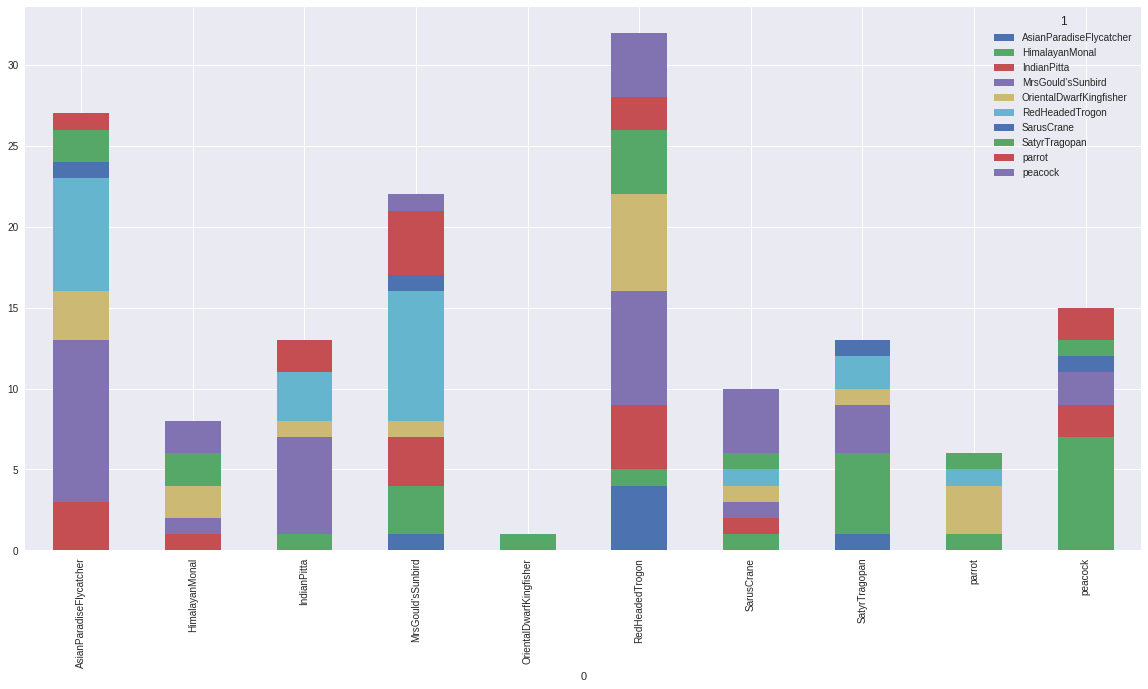

In [0]:
import pandas as pd
s_d = [(y,z) for x ,y,z in s]
df = pd.DataFrame(s_d)
gr = df.groupby([0,1])
gr.apply(len).unstack().plot(kind='bar', stacked=True, figsize=(20,10))


# Saving the Model



When it comes to saving and loading models, there are three core functions to be familiar with:

    1. torch.save: Saves a serialized object to disk. This function uses Python’s pickle utility for serialization. Models, tensors, and dictionaries of all kinds of objects can be saved using this function.
    
    2. torch.load: Uses pickle’s unpickling facilities to deserialize pickled object files to memory. This function also facilitates the device to load the data into (see Saving & Loading Model Across Devices).
    
    3. torch.nn.Module.load_state_dict: Loads a model’s parameter dictionary using a deserialized state_dict. For more information on state_dict, see What is a state_dict?.

There are many ways to save the model but we are gonna see the most recommended and safe here we are going to save the model parameters and while loading just load the weights

### Saving & Loading a General Checkpoint for Inference and/or Resuming Training

In [0]:
# Save:
def createCheckpoint(filename=Path("./LatestCheckpoint.pt")):
  checkpoint = {
              'epoch': 5,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              "batch_size":batch_size,
  } # save all important stuff
  torch.save(checkpoint , filename)
createCheckpoint()


In [0]:
# Load
'''
First Intialize the model and then just load it
model = TheModelClass(*args, **kwargs)
optimizer = TheOptimizerClass(*args, **kwargs)

'''

checkpoint = torch.load(Path("./LatestCheckpoint.pt"))
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
batch_size = checkpoint['batch_size']

model.eval() ## or model.train()
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.01
    lr: 0.005477457514062632
    weight_decay: 0
)

When saving a general checkpoint, to be used for either inference or resuming training, you must save more than just the model’s state_dict. It is important to also save the optimizer’s state_dict, as this contains buffers and parameters that are updated as the model trains. Other items that you may want to save are the epoch you left off on, the latest recorded training loss, external torch.nn.Embedding layers, etc.

To save multiple components, organize them in a dictionary and use torch.save() to serialize the dictionary. A common PyTorch convention is to save these checkpoints using the .tar file extension.

To load the items, first initialize the model and optimizer, then load the dictionary locally using torch.load(). From here, you can easily access the saved items by simply querying the dictionary as you would expect.

Remember that you must call model.eval() to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results. If you wish to resuming training, call model.train() to ensure these layers are in training mode.

In [0]:
# save the checkpoint to gdrive
from google.colab import drive
drive.mount('/content/gdrive')
!cp LatestCheckpoint.pt ./gdrive/My\ Drive/
#!cp  ./gdrive/My\ Drive/LatestCheckpoint.pt .

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# LrFinder and One Cycle Policy

### Now that our model is giving 88.68 % accuracy let's finetune the model
So we train the model in two steps
1. First we unfreeze half of the network and use lr finder algo to find optimum lr and then use once cycle policy to train
2. unfreeze the entire network and then use lr finder algo to find optimum lr and then use once cycle policy to train.

## Let's see how much better we can do with model

In [0]:
def unfreeze(model,percent=0.25):
  l = int(np.ceil(len(model._modules.keys())* percent))
  l = list(model._modules.keys())[-l:]
  print(f"unfreezing these layer {l}",)
  for name in l:
    for params in model._modules[name].parameters():
      params.requires_grad_(True)

def check_freeze(model):
  for name ,layer in model._modules.items():
    s = []
    for l in layer.parameters():
      s.append(l.requires_grad)
    print(name ,all(s))


In [0]:
# unfreeze half of the model
unfreeze(model ,0.40)
# check which layer is freezed or not
check_freeze(model)

unfreezing these layer ['layer3', 'layer4', 'avgpool', 'fc']
conv1 False
bn1 False
relu True
maxpool True
layer1 False
layer2 False
layer3 True
layer4 True
avgpool True
fc True


## Learning Rate Finder
 Basically in simple terms learning rate finder starts the lr from base lr which is usally a small value , eventually increasing lr using some anneal function.
 
 Different type of anneal functions are 
 1. Linear
 2. Exponential
 3. Cosine
 
For example :- suppose base lr is 0.001 and max lr is 5 and no of iteration is 20 
 $$
 no\ of\ iteration = \frac{training\ data}{batch\ size}
 $$
 
 Then basically annneal function helps the lr to go from base lr to max lr in steps and thus generating a loss graph which after visualizing we have to pick the lr from the graph where loss just start decreasing.
 
 we in this notebook will implement Linear and exponential annealing function.

In [0]:
class LinearScheduler(lr_scheduler._LRScheduler):
    """Linearly increases the learning rate between two boundaries over a number of iterations."""
    def __init__(self, optimizer, end_lr, num_iter):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(LinearScheduler,self).__init__(optimizer)

    def get_lr(self):
        # increement one by one
        curr_iter = self.last_epoch + 1
        # get the ratio
        pct = curr_iter / self.num_iter
        # calculate lr with this formulae start + pct * (end-start)
        return [base_lr + pct * (self.end_lr - base_lr) for base_lr in self.base_lrs]


class ExponentialScheduler(lr_scheduler._LRScheduler):
    """Exponentially increases the learning rate between two boundaries over a number of iterations."""

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialScheduler,self).__init__(optimizer)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        pct = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** pct for base_lr in self.base_lrs]
      
class CosineScheduler(lr_scheduler._LRScheduler):
    """Cosine increases the learning rate between two boundaries over a number of iterations."""

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(CosineScheduler,self).__init__(optimizer)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        pct = curr_iter / self.num_iter
        cos_out = np.cos(np.pi * pct) + 1
        return [self.end_lr + (base_lr - self.end_lr )/2 *cos_out for base_lr in self.base_lrs]

In [0]:
class LRFinder:
  
  def __init__(self, model  , optimizer , criterion ,start_lr=1e-7, device=None):
    
    self.model = model
    # Move the model to the proper device
    self.optimizer = optimizer
    self.criterion = criterion
    
    ## save the model intial dict
    self.save_file = Path("tmpfile")
    torch.save(self.model , self.save_file)    
    if device is None:
      self.device = next(model.parameters()).device
    else:
      self.device = device
    self.model.to(self.device)
    
    self.history = {"lr":[] , "losses":[]}
    for l in self.optimizer.param_groups:
      l["initial_lr"]=start_lr
    
    
  def reset(self):
    """ Resets the model to intial state """
    self.model = torch.load(self.save_file)
    self.model.train()
    self.save_file.unlink()
    return self.model
    
  def calculateSmmothingValue(self ,beta):
    n ,mov_avg=0,0
    while True :
      n+=1
      value = yield
      mov_avg = beta*mov_avg +(1-beta)*value
      smooth = mov_avg / (1 - beta **n )
      yield smooth
    
  def lrfind(self, trainLoader,end_lr=10,num_iter=150,step_mode="exp", loss_smoothing_beta=0.99, diverge_th=5): 
        """
         Performs the lrfind test

         Arguments:
            trainLoader : The data loader
            end_lr :  The maximum lr
            num_iter : Max iteratiom
            step_mode : The anneal function by default `exp` but can be either `linear` or `cos`
            smooth_f : The loss smoothing factor, value should be between [0 , 1[
            diverge_th: The max loss value after which training should be stooped
        """
              # Reset test results
        self.history = {"lr": [], "losses": []}
        self.best_loss = None
        self.smoothner = self.calculateSmmothingValue(loss_smoothing_beta)
        
        if step_mode.lower()=="exp":
          lr_schedule = ExponentialScheduler(self.optimizer , end_lr  , num_iter,)
        elif step_mode.lower()=="cos":
          lr_schedule = CosineScheduler(self.optimizer , end_lr  , num_iter)
        elif step.mode.lower()=="linear":
          lr_schedule = LinearScheduler(self.optimizer , end_lr  , num_iter)
        else:
          raise ValueError(f"expected mode is either {exp , cos ,linear} got {step_mode}")
        
        if 0 < loss_smoothing_beta >=1:
          raise ValueError("smooth_f is outside the range [0, 1[")
        
        iterator = iter(trainLoader)
        for each_iter in range(num_iter):
          try:
            data , target = next(iterator)
          except StopIteration:
            iterator = iter(trainLoader)
            data , target = next(iterator)
         
          loss = self._train_batch(data , target)
          
          # Update the learning rate
          lr_schedule.step()
          self.history["lr"].append(lr_schedule.get_lr()[0])
          # Track the best loss and smooth it if smooth_f is specified
          if each_iter == 0:
              self.best_loss = loss
          else:
              next(self.smoothner)
              self.best_loss = self.smoothner.send(loss)
              if loss < self.best_loss:
                  self.best_loss = loss

          # Check if the loss has diverged; if it has, stop the test
          self.history["losses"].append(loss)
          if loss > diverge_th * self.best_loss:
              print("Stopping early, the loss has diverged")
              break

        print("Learning rate search finished. See the graph with {finder_name}.plot()")            
  
  def _train_batch(self,data,target):
    # set to training mode
    self.model.train()
    #load data to device
    data ,target = data.to(self.device) ,target.to(self.device)
    
    #forward pass
    self.optimizer.zero_grad()
    output = self.model(data)
    loss = self.criterion(output,target)
    
    #backward pass
    loss.backward()
    self.optimizer.step()
    return loss.item()
  
  def plot(self):
    losses = self.history["losses"]
    lr = self.history["lr"]
    plt.semilogx(lr,losses)
    plt.xlabel("Learning rate")
    plt.ylabel("Losses ")
    

In [0]:
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.lrfind(data_loader["train"], end_lr=10, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


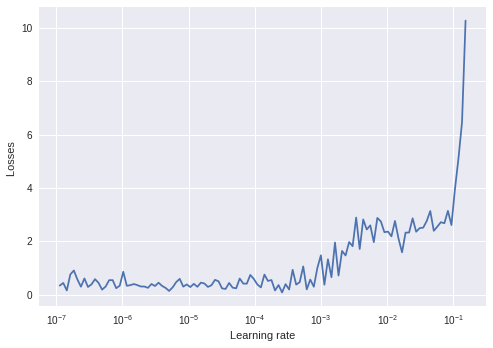

In [0]:
lr_finder.plot()

In [0]:
model= lr_finder.reset()

## [One Cycle Policy](https://sgugger.github.io/the-1cycle-policy.html)
one cycle policy is a technique in which the training process in divided into two section in first half the momentum is decreased and lr is increased and in other section we do the vice- versa

While using Adam we use beta1 property as momentum

But still there is this big question why one cycle policy .
1. This techniques helps model to converge faster.
2. Helps to take the model out of saddle point
3. Helps to stablilize the model by taking it out from local minima or sharp global minima instead getting the model into more flat surface on that curve.

![](https://sgugger.github.io/images/art5_full_schedule.png)

This times let's see another approach of modifying lr and momentum

In [0]:
class Stepper():
    "Used to \"step\" from start,end (`vals`) over `n_iter` iterations on a schedule defined by `func`"
    
    def __init__(self, val, n_iter:int, func):
        self.start,self.end = val
        self.n_iter = max(1,n_iter)
        self.func = func
        self.n = 0

    def step(self):
        "Return next value along annealed schedule."
        self.n += 1
        return self.func(self.start, self.end, self.n/self.n_iter)

    @property
    def is_done(self):
        "Return `True` if schedule completed."
        return self.n >= self.n_iter
    
# Annealing functions
def annealing_no(start, end, pct):
    "No annealing, always return `start`."
    return start
  
def annealing_linear(start, end, pct):
    "Linearly anneal from `start` to `end` as pct goes from 0.0 to 1.0."
    return start + pct * (end-start)
  
def annealing_exp(start, end, pct):
    "Exponentially anneal from `start` to `end` as pct goes from 0.0 to 1.0."
    return start * (end/start) ** pct

def annealing_cos(start, end, pct):
    "Cosine anneal from `start` to `end` as pct goes from 0.0 to 1.0."
    cos_out = np.cos(np.pi * pct) + 1
    return end + (start-end)/2 * cos_out

In [0]:

class OneCyclePolicy:
  
  def __init__(self,model , optimizer , criterion ,num_iteration,num_epochs,max_lr, momentum = (0.95,0.85) , div_factor=25 , pct_start=0.4, device=None ):
    
    self.model =model
    self.optimizer = optimizer
    self.criterion = criterion
    self.num_epochs = num_epochs
    if device is None:
      self.device = next(model.parameters()).device
    else:
      self.device = device
      
    n = num_iteration * self.num_epochs
    a1 = int(n*pct_start)
    a2 = n-a1
    self.phases = ((a1 , annealing_linear) , (a2 , annealing_cos))
    min_lr = max_lr/div_factor
    self.lr_scheds = self.steps((min_lr,max_lr) , (max_lr,min_lr/1e4))
    self.mom_scheds =self.steps(momentum , momentum[::-1])
    self.idx_s = 0
    self.update_lr_mom(self.lr_scheds[0].start,self.mom_scheds[0].start)
  
  def steps(self, *steps):
      "Build anneal schedule for all of the parameters."
      return [Stepper(step, n_iter, func=func)for (step,(n_iter,func)) in zip(steps, self.phases)]

  def train(self, trainLoader , validLoader ):
    self.model.to(self.device)
    data_loader = {"train":trainLoader , "val":validLoader}
    for epoch in tqdm(range(self.num_epochs),desc="Epochs"):
      result = []
      for phase in ['train', 'val']:
        if phase=="train":     # put the model in training mode
          model.train()
        else:     # put the model in validation mode
          model.eval()

        # keep track of training and validation loss
        running_loss = 0.0
        running_corrects = 0  

        for data , target in data_loader[phase]:
          #load the data and target to respective device
          data , target = data.to(device)  , target.to(device)

          with torch.set_grad_enabled(phase=="train"):
            #feed the input
            output = self.model(data)
            #calculate the loss
            loss = self.criterion(output,target)
            preds = torch.argmax(output,1)

            if phase=="train"  :
              # backward pass: compute gradient of the loss with respect to model parameters 
              loss.backward()
              # update the model parameters
              self.optimizer.step()
              # zero the grad to stop it from accumulating
              self.optimizer.zero_grad()
            
              self.update_lr_mom(self.lr_scheds[self.idx_s].step() ,self.mom_scheds[self.idx_s].step() )

              if self.lr_scheds[self.idx_s].is_done:
                self.idx_s += 1
          
          # statistics
          running_loss += loss.item() * data.size(0)
          running_corrects += torch.sum(preds == target.data).item()


        epoch_loss = running_loss / len(data_loader[phase].dataset)
        epoch_acc = running_corrects/ len(data_loader[phase].dataset)

        result.append('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
      print(result)

  def update_lr_mom(self,lr=0.001,mom=0.99):
    for l in self.optimizer.param_groups:
      l["lr"]=lr
      if isinstance(self.optimizer , ( torch.optim.Adamax,torch.optim.Adam)):
          l["betas"] = ( mom, 0.999)
      elif isinstance(self.optimizer, torch.optim.SGD):
          l["momentum"] =mom


In [0]:
fit_one_cycle = OneCyclePolicy(model ,optimizer , criterion,num_iteration=145  , num_epochs =8 , max_lr =1e-4 ,device=device)
fit_one_cycle.train(trainLoader,testLoader)












Epochs:   0%|          | 0/8 [00:00<?, ?it/s]










Epochs:  12%|█▎        | 1/8 [03:30<24:32, 210.30s/it]

['train Loss: 0.4062 Acc: 0.8746', 'val Loss: 24.9641 Acc: 0.9077']













Epochs:  25%|██▌       | 2/8 [07:00<21:01, 210.30s/it]

['train Loss: 0.4100 Acc: 0.8703', 'val Loss: 23.3653 Acc: 0.9042']













Epochs:  38%|███▊      | 3/8 [10:29<17:29, 209.81s/it]

['train Loss: 0.3954 Acc: 0.8791', 'val Loss: 14.7473 Acc: 0.9077']













Epochs:  50%|█████     | 4/8 [13:57<13:57, 209.48s/it]

['train Loss: 0.3990 Acc: 0.8756', 'val Loss: 21.8700 Acc: 0.9094']













Epochs:  62%|██████▎   | 5/8 [17:27<10:28, 209.39s/it]

['train Loss: 0.4174 Acc: 0.8705', 'val Loss: 16.5780 Acc: 0.9060']













Epochs:  75%|███████▌  | 6/8 [20:56<06:58, 209.41s/it]

['train Loss: 0.4087 Acc: 0.8776', 'val Loss: 12.5129 Acc: 0.8991']













Epochs:  88%|████████▊ | 7/8 [24:26<03:29, 209.41s/it]

['train Loss: 0.3968 Acc: 0.8825', 'val Loss: 13.0004 Acc: 0.9034']













Epochs: 100%|██████████| 8/8 [27:54<00:00, 209.05s/it]












['train Loss: 0.4017 Acc: 0.8802', 'val Loss: 26.7215 Acc: 0.9060']


In [0]:
print(perClassAccuracy(model , myDataset.classes))

AsianParadiseFlycatcher :- 92.623 %
HimalayanMonal :- 88.2353 %
IndianPitta :- 87.1795 %
MrsGould’sSunbird :- 82.6446 %
OrientalDwarfKingfisher :- 85.567 %
RedHeadedTrogon :- 88.2353 %
SarusCrane :- 98.1651 %
SatyrTragopan :- 89.4737 %
parrot :- 95.0 %
peacock :- 94.7712 %
total acc is 90.595340811044%


In [0]:
createCheckpoint(filename=Path("./latestCheckpoint90_59"))

In [0]:
!cp latestCheckpoint90_59 gdrive/My\ Drive/

Birds	   gdrive		  LatestCheckpoint.pt  train
Birds.zip  latestCheckpoint90_59  sample_data


## So after getting 90 accuracy the model can be finetunned more and we stopped here because this the accuracy I obtained using Fast.ai v1 library
1. By unfreezing more layers and training them
2. By performing Data Augmentation



# Additional Resources

https://cs231n.github.io/transfer-learning/

https://pytorch.org/tutorials/beginner/saving_loading_models.html

https://pytorch.org/docs/stable/torchvision/index.html

https://pytorch.org/docs/stable/optim.html

# Assignment 
 # Improve model to 93% accuracy and share the code